<a href="https://colab.research.google.com/github/koad7/graph_embedding_nlp/blob/main/Graph_nlp_liveproject1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade -q py2neo
!pip install -q umap-learn
!pip install -q hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.0/177.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 41.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import csv
import spacy
from tqdm.notebook import tqdm
from scipy.sparse import coo_matrix, save_npz
%matplotlib inline
import pandas as pd
from pathlib import Path
import gc


In [53]:
def del_gc_collect(var):
  del var
  gc.collect()



def deepgso(ob):
    """
    Convert bytes to human-readable units.
    """
    size = sys.getsizeof(ob)
    if isinstance(ob, (list,tuple,set)):
        for element in ob:
            size+=deepgso(element)
    if isinstance(ob, dict):
        for k,v in ob.items():
            size+=deepgso(k)
            size+=deepgso(v)

    for unit in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024.0:
            return f"{size:3.1f} {unit}"
        size /= 1024.0
    return size

In [6]:
!python -m spacy download en_core_web_md > /dev/null 2>&1

In [25]:
from google.colab import drive
# Check if the drive is already mounted
drive.flush_and_unmount()
if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
# Check the files in the current directory to ensure it's unzipped
DATA_DIR = "/content/drive/MyDrive/MSc_DATA_SCIENCE/FINAL_PROJECT/graph_tuto"

# Assuming DATA_DIR is already defined in your Colab notebook
DATA_DIR_ = Path(DATA_DIR)  # Convert to Path object for easier path manipulation


In [ ]:
# Check if the files do not exist
if not (DATA_DIR_ / "stat-abstracts.tsv").exists() and not (DATA_DIR_ / "stat-abstract-vectors.tsv.zip").exists():
  # Download the files
  !wget -P {DATA_DIR_} https://lp-prod-resources.s3.amazonaws.com/646/109102/2022-07-28-22-18-12/stat-abstract-vectors.tsv.zip
  !wget -P {DATA_DIR_} https://lp-prod-resources.s3.amazonaws.com/646/109102/2022-07-28-22-18-05/stat-abstracts.tsv

  # Unzip the file
  !unzip {DATA_DIR_}/stat-abstract-vectors.tsv.zip -d {DATA_DIR_}
else:
    print("Files stat-abstracts.tsv or stat-abstract-vectors.tsv.zip already exist. Skipping download.")


In [27]:
!tail -5 /content/drive/MyDrive/MSc_DATA_SCIENCE/FINAL_PROJECT/graph_tuto/stat-abstract-vectors.tsv

tail: cannot open '/content/drive/MyDrive/MSc_DATA_SCIENCE/FINAL_PROJECT/graph_tuto/stat-abstract-vectors.tsv' for reading: No such file or directory


In [9]:
ABSTRACT_FILE = os.path.join(DATA_DIR, "stat-abstracts.tsv")
ABS_VEC_FILE = os.path.join(DATA_DIR, "stat-abstract-vectors.tsv")
DOCIDS_LIST = os.path.join(DATA_DIR, "stat-av-docids.txt")
SIM_MATRIX_FILE = os.path.join(DATA_DIR, "av-simmatrix.npy")
ADJ_MATRIX_FILE = os.path.join(DATA_DIR, "av-adjmatrix.npz")

## 1-Load the spaCy language model.
We will represent documents as vectors using word embeddings. The spaCy medium and large provides 300-dimensional word vectors out of the box. Documents are represented by vectors that are the average of their word vectors. In our project, we will use the medium English language model (en_core_web_md).



In [10]:
nlp = spacy.load("en_core_web_md")

## 2-Extract document vectors.
We loop through the abstracts file provided to us, concatenating the title and text for each abstract. Concatenation involves terminating the title with a period and appending the abstract text to the end, essentially treating the title as the first sentence of the resulting text block representing the abstract, and the abstract as the rest. The concatenated text is passed to the spaCy language model. SpaCy will automatically return the average embedding vector described above for each text block.


In [ ]:
from tqdm.notebook import tqdm
from multiprocessing import Pool, cpu_count

# Assuming nlp is already loaded
# Assuming ABSTRACT_FILE and ABS_VEC_FILE are defined

def vectorize_text(args):
    text, nlp = args
    return nlp(text).vector

def join_title_text(title, abs_text):
    return title + " " + abs_text

def parallel_vectorize_texts(text_batch, nlp):
    with Pool(cpu_count()) as pool:
        vectors = pool.map(vectorize_text, [(text, nlp) for text in text_batch])
    return vectors

num_lines = 0
batch_size = 10000  # You can adjust this based on available memory
text_batch = []
id_batch = []

with open(ABSTRACT_FILE, "r") as fabs, open(ABS_VEC_FILE, "w") as fchk:
    for line in tqdm(fabs, desc="Vectorizing"):
        doc_id, title, categories, abs_text = line.strip().split('\t')
        text_batch.append(join_title_text(title, abs_text))
        id_batch.append(doc_id)

        if len(text_batch) == batch_size:
            vectors = parallel_vectorize_texts(text_batch, nlp)
            for doc_id, vec in zip(id_batch, vectors):
                vec_str = ",".join(["{:.3e}".format(v) for v in vec])
                fchk.write("{:s}\t{:s}\n".format(doc_id, vec_str))
            text_batch = []
            id_batch = []
            num_lines += batch_size

    # Process any remaining texts
    if text_batch:
        vectors = parallel_vectorize_texts(text_batch, nlp)
        for doc_id, vec in zip(id_batch, vectors):
            vec_str = ",".join(["{:.3e}".format(v) for v in vec])
            fchk.write("{:s}\t{:s}\n".format(doc_id, vec_str))
        num_lines += len(text_batch)

print("{:d} docs vectorized, COMPLETE".format(num_lines))


### 3. Construct a dense document matrix

Use the file of vectors generated (indicated by `ABS_VEC_FILE`) and create a list of document IDs (`docids`) and a list of vectors (`vecs`). Each element of the list `vecs` must be a numpy array of size (300,).

The next cell displays the size of the `docids` and `vecs` list. Verify that they are identical. Also verify that the elements of the list `vecs` are numpy vectors of size (300,).



In [48]:
docids, vecs = [], []
with open(ABS_VEC_FILE, "r") as fav:
    num_recs = 0
    for line in fav:
        if num_recs % 10000 == 0:
            print("{:d} vectors read".format(num_recs))
        doc_id, vec_str = line.strip().split('\t')
        vec = np.array([float(x) for x in vec_str.split(",")])
        vecs.append(vec)
        docids.append(doc_id)
        num_recs += 1

print("{:d} vectors read, COMPLETE".format(num_recs))

0 vectors read
10000 vectors read
20000 vectors read
30000 vectors read
40000 vectors read
50000 vectors read
50426 vectors read, COMPLETE


In [49]:
print("number of docIDs:", len(docids))
print("number of vectors:", len(vecs))
print("shape of vector in vecs:", vecs[0].shape)

number of docIDs: 50426
number of vectors: 50426
shape of vector in vecs: (300,)


We now convert the list of (300,) vectors into a matrix of documents. There are 50426 documents in the corpus, so verify that the shape of the matrix is (50426, 300).

In [50]:
X = np.array(vecs)
X.shape

(50426, 300)

### 4. Construct a document similarity matrix

We use cosine similarity as our similarity measure. The formula for cosine similarity between a pair of documents vectors $d_1$ and $d_2$ is given by:

$$cosim(d_1, d_2) = \frac{d_1 \cdot d_2}{{\lvert d_1 \rvert}_2 {\lvert d_2 \rvert}_2}$$

We can also compute the cosine similarity between all pairs of documents in the document matrix X using the following formula.

$$S = \frac{X \cdot X^T}{{\lvert X \rvert}_2^2}$$

Since the denominator on the RHS is a constant, we can re-state the equation above as:

$$S \propto X \cdot X^T$$



**NOTE: this is a time consuming operation. If you would rather skip this, please download the serialized version of the similarity matrix from the code repository for this liveProject and load it into the variable `S` by uncommenting the commented code in the next cell instead (the one containing S = np.load(SIM_MATRIX_FILE).**

```
wget http://download.location/.../av-simmatrix.npy .
```


In [51]:
S = np.dot(X, X.T)
S.shape

(50426, 50426)

## 5-Determine similarity threshold.
- The resulting similarity matrix is dense since the document vectors are dense as well. If we built a graph out of this, it would be extremely dense and not provide us with meaningful insights. So we need to establish a similarity threshold above which we will consider a document pair to be related, and below which they would be considered unrelated.
- We do this by sampling from the similarity matrix and building a histogram of scores. We determine the threshold by inspecting the histogram. The objective is to build an adjacency matrix that represents a graph that is sparse enough to provide a meaningful structure. That is, we connect two documents only if there is a very high similarity.
- Unfortunately, this is somewhat subjective and you might need a few attempts with different thresholds in order to get a meaningful threshold.
- Building the histogram against the full document set is quite compute-intensive, so to enable quick development cycles, we sample about 2% of the data (1000 documents) randomly and generate the histogram from it.
- A good rule of thumb might be to set the threshold to only include edges with weights that are in the top 1–5% of the population.



We sample around 1000 elements from the similarity matrix and plot a histogram to get an idea of the distribution of cosine similarity scores.

We want to draw edges only between documents with relatively high similarity. Based on the histogram, a good threshold seems to be 9.5.

(array([  1.,   2.,   6.,  15.,  45., 116., 247., 312., 207.,  49.]),
 array([4.64514807, 5.16227497, 5.67940188, 6.19652878, 6.71365568,
        7.23078258, 7.74790948, 8.26503638, 8.78216329, 9.29929019,
        9.81641709]),
 <BarContainer object of 10 artists>)

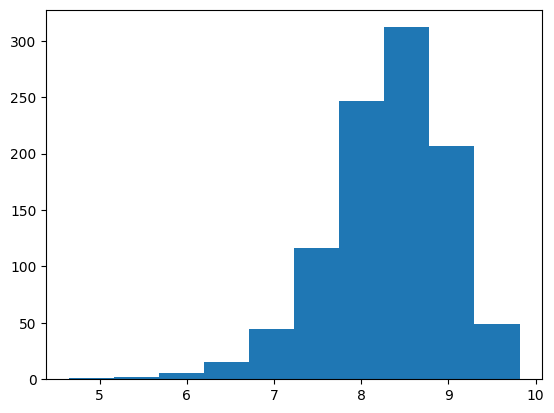

In [34]:
row_indices = np.random.randint(0, S.shape[0], 1000)
col_indices = np.random.randint(0, S.shape[1], 1000)
samples = []
for row, col in zip(row_indices, col_indices):
    samples.append(S[row, col])

plt.hist(samples)


## 6-Create an adjacency matrix.
Remember to set the diagonal to zero. A document is most similar to itself, therefore diagonal elements would be highest, but we are not interested in this relation for our graph.
Update the similarity matrix such that any value above the threshold is 1 and any values below it are 0.

We can now create an adjacency matrix `A` from the similarity matrix `S`. An adjacency matrix is a square matrix of the same size as the similarity matrix, i.e. an (N, N) matrix where N is the number of documents. An element `A[i, j]` is 1 if there is high similarity between $doc_i$ and $doc_j$, i.e. similarity above the threshold.

Also remember to set the diagonal elements of the adjacency matrix to 0. For similarity matrices, the highest values are on the diagonal, since a document is most similar to itself. However, that would translate to self-loops in a graph, which we don't care about.

In [52]:
threshold = 9.5

A = np.zeros(S.shape)
ones_indices = S >= threshold
A[ones_indices] = 1

np.fill_diagonal(A, 0)

## 7-Save the adjacency matrix for the next milestone.
Remember to save the adjacency matrix representing the document graph for the next milestone. We will need the adjacency matrix and a pointer from each row position back to the document ID.

<50426x50426 sparse matrix of type '<class 'numpy.int8'>'
	with 51207968 stored elements in COOrdinate format>

In [55]:
# np.save(ADJ_MATRIX_FILE, A)
#save_npz(ADJ_MATRIX_FILE, coo_matrix(A))
A_=A.astype(np.int8)
A_coo = coo_matrix(A_)
save_npz(ADJ_MATRIX_FILE, A_coo)

In [59]:
fdocs = open(DOCIDS_LIST, "w")
for i, doc_id in enumerate(docids):
    fdocs.write("{:s}\t{:d}\n".format(doc_id, i))
fdocs.close()

In [ ]:
# Save to the matrice to Google Drive
#Intermediary_matrice_file_path = "/content/drive/MyDrive/MSc_DATA_SCIENCE/FINAL_PROJECT/graph_tuto/av-adjmatrix_intermed.npy"
#np.save(Intermediary_matrice_file_path, A)

In [60]:
PATTERN = "av"

# our inputs from previous milestones
# input to milestone 1
ABSTRACTS_FILE = os.path.join(DATA_DIR, "stat-abstracts.tsv")
# outputs of milestone 1
DOCIDS_FILE = os.path.join(DATA_DIR, "stat-{:s}-docids.txt".format(PATTERN))
INPUT_MATRIX_FILE = os.path.join(DATA_DIR, "{:s}-adjmatrix.npz".format(PATTERN))

# our deliverables from milestone 2
NODE_FILE = os.path.join(DATA_DIR, "{:s}-node.csv".format(PATTERN))
RELS_FILE = os.path.join(DATA_DIR, "{:s}-edges.csv".format(PATTERN))

### Deserialize mapping of row/col id to docID

Our adjacency matrix we generated in the previous milestone is available to us as a numpy serialized file. On deserializing, we will get a square matrix of size (50426, 50426), where 50426 is the number of articles provided to us in our initial dataset.

Since we need to think in terms of a graph of actual documents now, we would like to relate the row / column ids in the adjacency matrix to actual articles and their document IDs. Therefore we need to produce a mapping of row / column ids to their corresponding article IDs.

Read the file indicated by `DOCIDS_FILE` and extract from it a dictionary mappng the row / column ID to the article `docID`. Call this dictionary `id_to_docid`.

In [61]:
id_to_docid = {}

num_docs = 0
with open(DOCIDS_FILE, "r") as fdocs:
    for line in fdocs:
        if num_docs % 10000 == 0:
            print("{:d} doc IDS read".format(num_docs))
        doc_id, lid = line.strip().split('\t')
        lid = int(lid)
        id_to_docid[lid] = doc_id
        num_docs += 1

print("{:d} doc IDS read, COMPLETE".format(num_docs))
len(id_to_docid)

0 doc IDS read
10000 doc IDS read
20000 doc IDS read
30000 doc IDS read
40000 doc IDS read
50000 doc IDS read
50426 doc IDS read, COMPLETE


50426

### Create mapping of docID to (title, category)

In order to create our **nodes.csv** file, we need the ability to look up the document title and category from the input file (indicated by `ABSTRACTS_FILE`) provided to us.

The `ABSTRACTS_FILE` contains the `docID`, `title`, `categories` and `abstract_text` for each article. To keep things simple, we will set the article category to the first `stat` category that the authors have marked it up with. Write a function that will take a concatenated set of categories separated by the semi-colon (";") character, and select the first category that starts with the string "stat.". Assign this category to the variable `first_stat_cat`.

In [62]:
def get_first_stat_category(categories_str):
    first_stat_cat = None
    cats = categories_str.split(";")
    for cat in cats:
        if cat.startswith("stat."):
            first_stat_cat = cat
            break
    if first_stat_cat is None:
        return cats[0]
    return first_stat_cat


# test your function, you should get stat.SE
get_first_stat_category("cs.ML;stat.SE;stat.TH")

'stat.SE'

Next, we will parse the `ABSTRACTS_FILE` to extract `docID`, `title` and `categories` fields. We will extract the first `stat.*` category from the categories.

In [63]:
docid_to_title_cat = {}

num_docs = 0
with open(ABSTRACTS_FILE, "r") as fabs:
    for line in fabs:
        if num_docs % 10000 == 0:
            print("{:d} doc IDs read".format(num_docs))
        doc_id, title, cats, _ = line.strip().split('\t')
        stat_cat = get_first_stat_category(cats)
        docid_to_title_cat[doc_id] = (title, stat_cat)
        num_docs += 1

print("{:d} doc IDs read, COMPLETE".format(num_docs))
len(docid_to_title_cat)

0 doc IDs read
10000 doc IDs read
20000 doc IDs read
30000 doc IDs read
40000 doc IDs read
50000 doc IDs read
50426 doc IDs read, COMPLETE


50426

### Create the nodes CSV file

Using the `id_to_docid` and `docid_to_title_cat` dictionaries you just created, write out the nodes CSV file **nodes.csv** indicated by `NODE_FILE` above.

As a reminder, here is what the output should look like.

**nodes.csv**

```
doc_id:ID,title,category,:LABEL
0704.0302,Spline Single-Index Prediction Model,stat.TH,Article
0704.0326,On generalized entropy measures and pathways,stat.TH,Article
...
```

Make sure to handle commas within the `title` field, either by quoting the title or replacing the comma character in the title with some other character.

In [64]:
num_docs = 0
fnode = open(NODE_FILE, "w")

## write out the header as shown in the example
fnode.write("doc_id:ID,title,category,:LABEL\n")

for i in range(len(id_to_docid)):
    if num_docs % 10000 == 0:
        print("{:d} nodes written".format(num_docs))
    ## write out each line as shown in the example
    doc_id = id_to_docid[i]
    title, cat = docid_to_title_cat[doc_id]
    title = title.replace("\"", "'").replace(",", " ")
    fnode.write("{:s},{:s},{:s},Article\n".format(doc_id, title, cat))
    num_docs += 1

print("{:d} nodes written, COMPLETE\n".format(num_docs))
fnode.close()

0 nodes written
10000 nodes written
20000 nodes written
30000 nodes written
40000 nodes written
50000 nodes written
50426 nodes written, COMPLETE



### Check your work

The `check_csv` function below checks that your CSV file contains the correct number of columns and rows, otherwise it will error out and give you the line number in the file where there was a problem. We expect our `node.csv` file to have 4 columns per line and 50426 lines, since we are extracting the attributes `docID`, `title`, `category` and `type` for each of 50426 articles in our dataset.

**If your node.csv file looks good, you should see NO OUTPUT from the `check_csv` function.**

In [65]:
def check_csv(file_path, expected_num_cols, expected_num_rows):
    with open(file_path, "r") as fcsv:
        reader = csv.reader(fcsv)
        for i, row in enumerate(reader):
            if len(row) != expected_num_cols:
                print("Invalid CSV file: {:d} columns in line {:d}, expected {:d}"
                      .format(len(row), i+1, expected_num_cols))
                break
        if i != expected_num_rows:
            print("Invalid CSV file: {:d} rows found, expected {:d}".format(i, expected_num_rows))


check_csv(NODE_FILE, 4, 50426)

### Deserialize the Adjacency Matrix

Deserialize the Adjacency Matrix you created from the last milestone (indicated by `INPUT_MATRIX_FILE`). Verify that the shape of the matrix is `(50426, 50426)`.

If you have saved the adjacency matrix as a dense matrix (i.e., using `np.save()`) in the last milestone, then you should use `np.load()` to deserialize. If you saved it as a sparse COO matrix (our recommended approach), then you should use `load_npz()` instead. Deserializing from a sparse representation is significantly faster than deserializing from a dense representation.

In [66]:
#from scipy.sparse import load_npz

#A = load_npz(INPUT_MATRIX_FILE).todense()
A.shape

(50426, 50426)

### Create the edges.csv file

Use the deserialized matrix `A` and our `id_to_docid` dictionary to create the **edges.csv** file indicated by `RELS_FILE`. As a reminder, here is what the output should look like.

```
:START_ID,:END_ID,:TYPE
0704.0302,1802.02649,SIMILAR_TO
0704.0517,0704.0744,SIMILAR_TO
...
```

Remember that graph edges in this situation is based on document similarity, and is hence symmetric, i.e. if articles $doc_i$ and $doc_j$ are similar according to the adjacency matrix, then `A[i, j] == A[j, i]`. While Neo4j supports directed edges only, the Cypher query language can ignore the edge direction when querying the graph. Therefore, when creating the graph, we will specify only a single edge between any given $doc_i$, $doc_j$ pair.

Also remember that typically adjacency matrices that are designed based on similarity have the highest values along the diagonal (i.e. a document is most similar with itself), so in the general case you should correct for that as well.

A good way to do this is to look only at non-zero entries in `A` where `i < j`, i.e.,

```
if i < j and A[i, j] > 0:
    # add an edge between i and j
```

**NOTE: This operation will take some time to complete!**

In [70]:
num_docs, num_edges = 0, 0
frels = open(RELS_FILE, "w")
frels.write(":START_ID,:END_ID,:TYPE\n")

# Iterate over non-zero elements of the sparse matrix
for i, j, v in zip(A_coo.row, A_coo.col, A_coo.data):
    if v > 0 and i < j:
        start_id = id_to_docid[i]
        end_id = id_to_docid[j]
        frels.write("{:s},{:s},SIMILAR_TO\n".format(start_id, end_id))
        num_edges += 1
    if i % 10000 == 0:
        print("{:d} docs read".format(num_docs))
    num_docs += 1

print("{:d} docs read, COMPLETE".format(num_docs))
print("--")
print("{:d} edges written, COMPLETE".format(num_edges))
frels.close()


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
10830770 docs read
10830771 docs read
10830772 docs read
10830773 docs read
10830774 docs read
10830775 docs read
10830776 docs read
10830777 docs read
10830778 docs read
10830779 docs read
10830780 docs read
10830781 docs read
10830782 docs read
10830783 docs read
10830784 docs read
10830785 docs read
10830786 docs read
10830787 docs read
10830788 docs read
10830789 docs read
10830790 docs read
10830791 docs read
10830792 docs read
10830793 docs read
10830794 docs read
10830795 docs read
10830796 docs read
10830797 docs read
10830798 docs read
10830799 docs read
10830800 docs read
10830801 docs read
10830802 docs read
10830803 docs read
10830804 docs read
10830805 docs read
10830806 docs read
10830807 docs read
10830808 docs read
10830809 docs read
10830810 docs read
10830811 docs read
10830812 docs read
10830813 docs read
10830814 docs read
10830815 docs read
10830816 docs read
10830817 docs read
10830818 d

### Check your work

**If your edges.csv file looks good, you should see no output from the call to `check_csv` below.**

In [72]:
check_csv(RELS_FILE, 3, 25603984)

### Compute graph sparsity

As a fun exercise, compute the graph sparsity. That is compute the ratio of `num_edges` and the maximum number of possible edges for a fully connected graph.

The maximum number of edges possible would be `num_nodes` * `(num_nodes - 1)`. This will give us two edges between any two nodes i and j. However, since the `SIMILAR_TO` relationship is symmetric, we should consider only one edge.

Your answer rounded to 2 decimal places should be `0.02`.

In [73]:
sparsity = num_edges / (A.shape[0] * (A.shape[0] - 1) / 2)
sparsity

0.020138963576191042

# Explore Graph using Neo4j

In this section we will explore the graph we just created using Cypher and the Graph Data Science (GDS) library for Neo4j.

In [ ]:
NEO4J_DUMP = os.path.join(DATA_DIR, "neo4j-dump.json")
NEO4J_LABELS = os.path.join(DATA_DIR, "neo4j-labels.tsv")

NODE_VEC_FILE = os.path.join(DATA_DIR, "stat-abstract-vectors.tsv")

## Connect to Neo4j server

The code below connects to the Neo4j server using the `bolt` interface.

For a sanity check, enter a Cypher query to count the number of nodes of type `Article` in the graph. You should see 50427 nodes

In [ ]:
!ls $DATA_DIR

 av-adjmatrix_intermed.npy      av-edges.csv
 av-adjmatrix.npz	        av-edges.gsheet
 av-adjmatrix.npz_chunk_0.npz   av-node.csv
 av-adjmatrix.npz_chunk_1.npz   av-node.gsheet
 av-adjmatrix.npz_chunk_2.npz   stat-abstracts.tsv
 av-adjmatrix.npz_chunk_3.npz   stat-abstract-vectors.tsv
 av-adjmatrix.npz_chunk_4.npz   stat-abstract-vectors.tsv.zip
 av-adjmatrix.npz_chunk_5.npz   stat-av-docids.txt
'av-edges (1).gsheet'


In [ ]:
!head -2 $DATA_DIR/av-edges.csv

:START_ID,:END_ID,:TYPE
0704.0302,0704.0326,SIMILAR_TO


In [ ]:
!head -2 $DATA_DIR/av-node.csv

doc_id:ID,title,category,:LABEL
0704.0302,Spline Single-Index Prediction Model,stat.TH,Article


In [ ]:
!head -2 $DATA_DIR/av-node.csv